<a href="https://colab.research.google.com/github/deltorobarba/machinelearning/blob/master/causality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Granger Causality**

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# **Relevance**

In order to determine whether one time series causes another, the most common approach is the so-called **Granger causality test**.

The Granger causality test is a statistical hypothesis test for determining whether one time series is useful in forecasting another, first proposed in 1969. Ordinarily, regressions reflect "mere" correlations, but Clive Granger argued that causality in economics could be tested for by measuring the ability to predict the future values of a time series using prior values of another time series.

Granger defined the causality relationship based on two principles:

* The cause happens prior to its effect.
* The cause has unique information about the future values of its effect.


A time series X is said to **Granger-cause** Y if it can be shown, usually through a series of t-tests and F-tests on lagged values of X (and with lagged values of Y also included), that those X values provide statistically significant information about future values of Y.

If a time series is a **stationary process**, the test is performed using the level values of two (or more) variables. If the variables are non-stationary, then the test is done using first (or higher) differences. The number of lags to be included is usually chosen using an information criterion, such as the Akaike information criterion or the Schwarz information criterion. 

# **Data Preprocessing**

**Import data**

In [0]:
url = 'https://raw.githubusercontent.com/deltorobarba/machinelearning/master/google.csv'
data = pd.read_csv(url)
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-02-01,266.301849,266.904572,264.159851,265.514771,265.514771,4518400
1,2010-02-02,266.481171,266.481171,262.819885,264.568329,264.568329,8223000
2,2010-02-03,263.347900,270.037842,263.128723,269.400208,269.400208,6020500
3,2010-02-04,267.497345,267.995483,261.798706,262.406433,262.406433,6780600
4,2010-02-05,263.213409,265.753876,260.254517,264.653015,264.653015,6335600


**Preprocess Original Series**

In [0]:
# preprocess = data.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume']) # Alternative to select below
preprocess = data[['Date', 'Close']].rename(columns={"Date": "date", "Close": "price"}).set_index('date')
preprocess.index = pd.to_datetime(preprocess.index, utc=False)
preprocess.head()

,price
date,
2010-02-01,265.514771
2010-02-02,264.568329
2010-02-03,269.400208
2010-02-04,262.406433
2010-02-05,264.653015


**Create Additional Series for Granger Causality Test**

* We are adding a series that is simply a copy of the original series but shifted by t-1. This is a 'ideal case' since in financial time series the previous time step determines to a strong degree the next one.
* Let's also add some gaussian noise with standard deviation and a non-zero mean to the new time series, so that it's not exactly a 1:1 of the original time series

In [0]:
# Define noise
mean = 50 # mean of the distribution
sigma = 7 # standard deviation of distribution
sample = preprocess.price.count() # number of elements in array

noise = (np.random.normal(mean,sigma,sample))

* *Fun fact*: 7 sigma (standard deviations) are chosen from the normal distribution. From the rules for normally distributed data for a daily event this corresponds to a [approximate frequency for daily events](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule#Table_of_numerical_values) every 1.07 billion years (four times in history of Earth).

In [0]:
# Create final table with additional series called 'past'
series = preprocess.rename(columns={'price' : 'present'})
series['past'] = ((series.present).shift(-1) + noise).dropna()
series.head()

,present,past
date,,
2010-02-01,265.514771,303.661233
2010-02-02,264.568329,307.650709
2010-02-03,269.400208,324.775622
2010-02-04,262.406433,309.961148
2010-02-05,264.653015,310.964875


In [0]:
# Augmented Dickey Fuller. H0: There is a unit root for the series (non stationary)
from statsmodels.tsa.stattools import adfuller
adfuller(series.present, maxlag=None, regression='ctt', autolag='AIC', store=False, regresults=False)

(-4.062315034834605,
 0.02630244592391451,
 18,
 2497,
 {'1%': -4.375776615294273,
  '10%': -3.5547264517170936,
  '5%': -3.8347571289440716},
 18853.98361280409)

**Difference both Series**

Granger causality requires stationary time series as input

In [0]:
differenced = series
differenced = differenced.drop(columns=['present', 'past'])
differenced['present'] = ((series.present) - ((series.present).shift(1)))
differenced['past'] = ((series.past) - ((series.past).shift(1)))
differenced = differenced.dropna()
differenced.head()

,present,past
date,,
2010-02-02,-0.946442,3.989476
2010-02-03,4.831879,17.124913
2010-02-04,-6.993775,-14.814474
2010-02-05,2.246582,1.003727
2010-02-08,1.085938,5.919371


**Exkurs: Add & Query Price Delta**

In [0]:
# Add delta between previous and current price (Take absolute values of delta and round percentage values)
series['delta'] = (series['present'] - series['past']).abs().round(2)
series['percent'] = ((series['delta'] / series['present'])*(100)).round(2)
series = series.sort_values(by='delta', ascending=False)
series.head()

,present,past,delta,percent
date,,,,
2019-07-25,1132.119995,1302.259564,170.14,15.03
2015-07-16,579.849976,726.294922,146.44,25.25
2018-12-24,976.219971,1091.212074,114.99,11.78
2013-10-17,442.735504,553.850472,111.11,25.10
2019-01-03,1016.059998,1122.101606,106.04,10.44


In [0]:
# How many times went the delta was larger than 100 USD?
"In %s%% of all days the price delta was > 100 USD" % np.int_(len(series.loc[series.delta > 100]) / len((series.delta)) * 10000)

'In 19% of all days the price delta was > 100 USD'

In [0]:
# Remove added values again because we won't need them anymore, and resort by datetime
series = series.drop(columns=['delta', 'percent']).sort_index(ascending=True)
series.head()

,present,past
date,,
2010-02-01,265.514771,303.661233
2010-02-02,264.568329,307.650709
2010-02-03,269.400208,324.775622
2010-02-04,262.406433,309.961148
2010-02-05,264.653015,310.964875


**Clean Data Analysis**

In [0]:
# Check for Missing Values
series.apply(lambda x: sum(x.isnull()),axis=0) 
# series.isnull().sum() # Alternative

present    0
past       1
dtype: int64

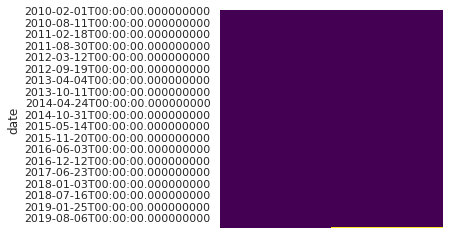

In [0]:
# Check for Missing Values (Visualization)
sns.set(rc={'figure.figsize':(4, 4)})
sns.heatmap(series.isnull(),xticklabels=False,cbar=False,cmap='viridis')

In [0]:
# Check for zeros
(series[series == 0]).count()

present    0
past       0
dtype: int64

# **Exploratory Data Analysis**

Since both series originate in the same time series (just one was shifted and enriched with some gaussian noise), we will continue analyzing only the 'present' data time series.

* What is the distribution?
* Is there autocorrelation?
* Are data stationary? Is there a trend or seasonality?

## **Distribution**

Before applying a causality test, we'll run a simple regression first. However, if the distribution of the time series is not normal, the application of robust regression is recommendable. So let's first run a goodness of fit test again normal distribution.

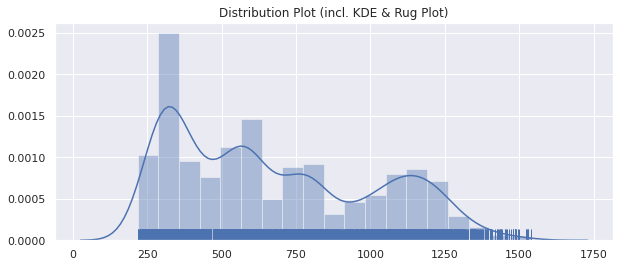

In [0]:
sns.set(rc={'figure.figsize':(10, 4)})
sns.distplot((series), hist=True, rug=True).set_title('Distribution Plot (incl. KDE & Rug Plot)')
plt.show()

Text(0.5, 1.0, 'Boxplot')

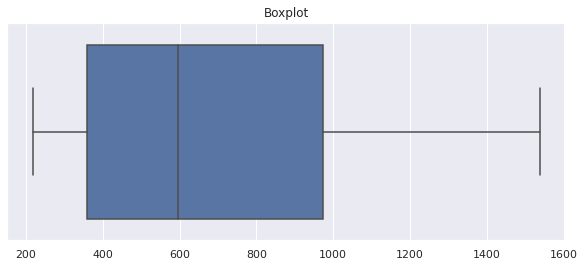

In [0]:
sns.boxplot(series).set_title('Boxplot')

In [0]:
# Normal Test. H0: sample comes from a normal distribution
import scipy
from scipy import stats
stats.normaltest(series.present)

NormaltestResult(statistic=729.881818875314, pvalue=3.222380423509462e-159)

Reject H0. Data are not drawn from a normal distribution.

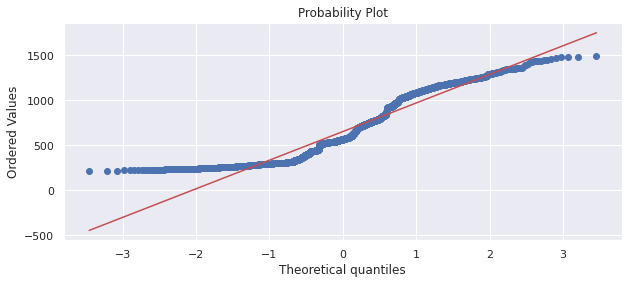

In [0]:
# QQ Plot against normal distribution
import scipy
from scipy import stats
sns.set(rc={'figure.figsize':(10, 4)})
stats.probplot(series.present, dist="norm", plot=plt)
plt.show()

Visual confirmation that data is not normally distributed. 

## **Autocorrelation**

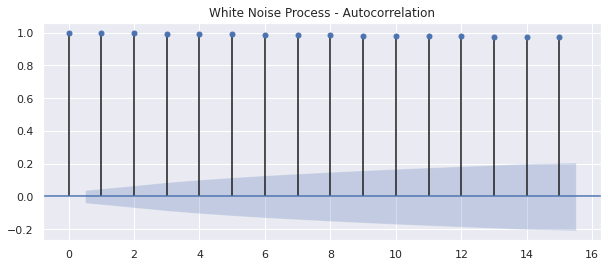

In [0]:
sns.set(rc={'figure.figsize':(10, 4)})

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(series.present.squeeze(), lags=15)
plt.title('White Noise Process - Autocorrelation')
plt.show()

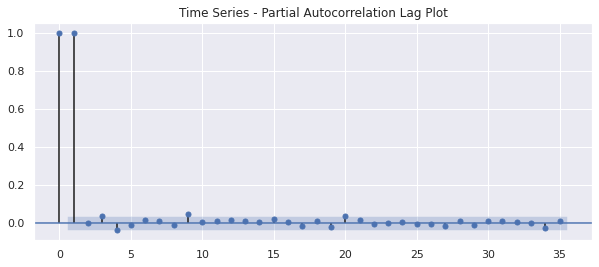

In [0]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(series.present)
plt.title('Time Series - Partial Autocorrelation Lag Plot')
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


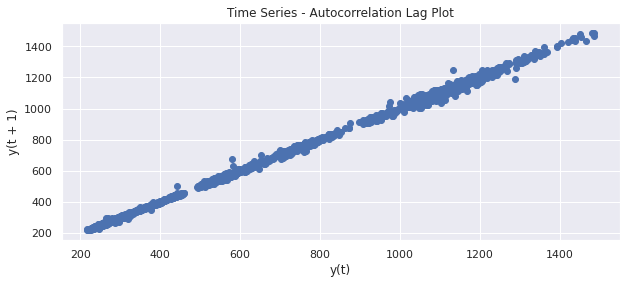

In [0]:
from pandas.plotting import lag_plot
lag_plot(series.present)
plt.title('Time Series - Autocorrelation Lag Plot')
plt.show()

In [0]:
# Durban-Watson Statistic. Value 2: no serial correlation. 0: positive correlation. 4: negative correlation
import statsmodels.api as sm
import statsmodels.tsa.stattools
statsmodels.stats.stattools.durbin_watson(series.present, axis=0)

0.0002163041853443746

Evidence for positive serial correlation.

## **Stationarity**

Granger causality (1969) requires both series to be stationary, so let's test whether this is true for both time series, and difference them until they are stationary. Most financial time series exhibit a unit root and need to be differenced once. Additionally they demonstrate a trend upward ('random walk with drift'). Also there might some seasonality.

**Trend & Seasonality**

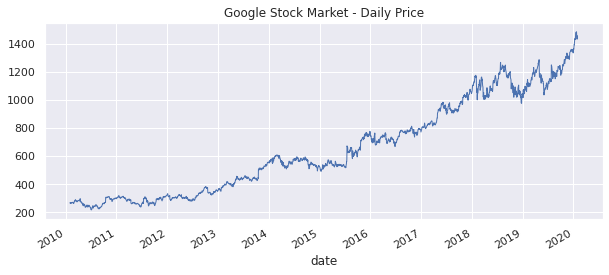

In [0]:
sns.set(rc={'figure.figsize':(10, 4), "lines.linewidth": 1.0})
series.present.plot(title='Google Stock Market - Daily Price')
# You can slice out a certain time period: df = series.present['2010-02-01':'2011-02-01']

Reviewing the time series plot above, it suggests that there may be a linear trend, but it is hard to be sure from eye-balling. There may be no seasonality, and the amplitude (height) of the variance appears to be increasing, suggesting that it is multiplicative.

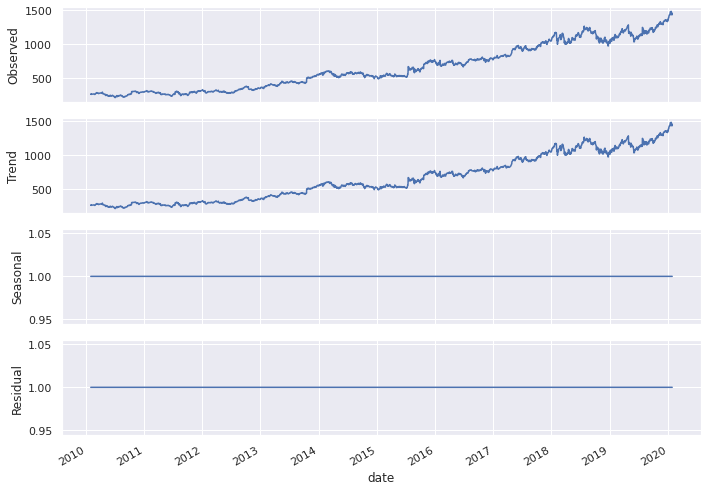

In [0]:
sns.set(rc={'figure.figsize':(10, 7)})

from statsmodels.tsa.seasonal import seasonal_decompose
decompose = series.present
result = seasonal_decompose(decompose, model='multiplicative', freq=1) # or additive
# print(result.trend)
# print(result.seasonal)
# print(result.resid)
# print(result.observed)
result.plot()
plt.show()

Looks like the entire series was taken as the trend component and that there was no seasonality. The type of trend will be later determined under the (non)stationarity tests.

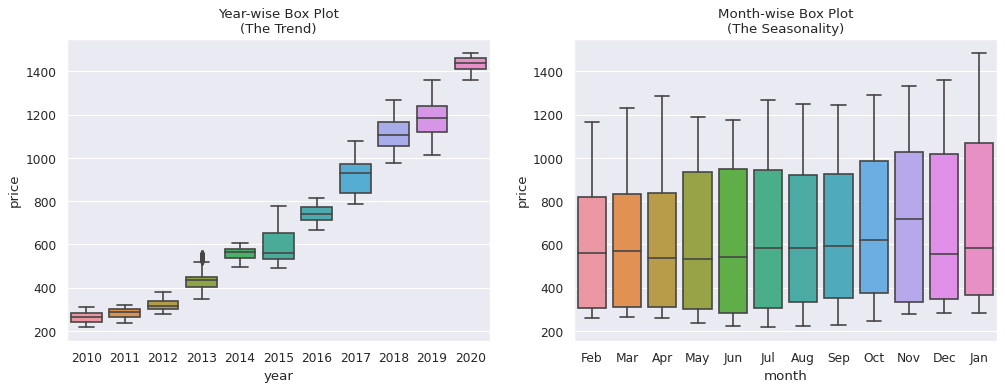

In [0]:
seasonal_plots = preprocess.copy()

seasonal_plots.reset_index(inplace=True)

# Prepare data
seasonal_plots['year'] = [d.year for d in seasonal_plots.date]
seasonal_plots['month'] = [d.strftime('%b') for d in seasonal_plots.date]
years = seasonal_plots['year'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(15,5), dpi= 80)
sns.boxplot(x='year', y='price', data=seasonal_plots, ax=axes[0])
sns.boxplot(x='month', y='price', data=seasonal_plots.loc[~seasonal_plots.year.isin([1991, 2008]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=12); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=12)
plt.show()

There is a trend visible, but not so much a seasonality. A trend can be removed with differencing, but let's run a stationarity test first.

**Stationarity Test**

In [0]:
from statsmodels.tsa.stattools import adfuller

series1 = series.present
series2 = series.past

def adf_tests(series1, series2):
  adf1 = adfuller((series1), maxlag=None, regression='nc', autolag='AIC', store=False, regresults=False)
  adf2 = adfuller((series2), maxlag=None, regression='nc', autolag='AIC', store=False, regresults=False)
  return (adf1, adf2)

In [0]:
stationarity = adf_tests(series1, series2)
stationarity

((2.9224506092809115,
  0.9997106586717946,
  20,
  2495,
  {'1%': -2.5666366948727113,
   '10%': -1.6167139814432983,
   '5%': -1.9411081938603896},
  18866.08557404916),
 (nan,
  nan,
  0,
  2515,
  {'1%': -2.566629559501836,
   '10%': -1.6167148211193927,
   '5%': -1.9411073292389265},
  nan))

**Stationarity Test (Past)**

In [0]:
# Augmented Dicker Fuller test. H0: There is a unit root for the series (non stationary)
from statsmodels.tsa.stattools import adfuller
adfuller(series.past, maxlag=None, regression='nc', autolag='AIC', store=False, regresults=False)

(nan,
 nan,
 0,
 2515,
 {'1%': -2.566629559501836,
  '10%': -1.6167148211193927,
  '5%': -1.9411073292389265},
 nan)

p-value above 0.05. Not reject H0. Series is not stationary Transformation for Granger test required (difference time series).

In [0]:
from statsmodels.tsa.stattools import adfuller
adfuller(differenced.past, maxlag=None, regression='nc', autolag='AIC', store=False, regresults=False)

(-11.432490487957478,
 9.355431899618207e-21,
 19,
 2494,
 {'1%': -2.566637054647272,
  '10%': -1.616713939107425,
  '5%': -1.941108237457268},
 20137.469622549997)

Past series is now stationary. They have been a unit root before, since it had to be differenced once only.

**Stationarity Test (Present)**

In [0]:
from statsmodels.tsa.stattools import adfuller
adfuller(series.present, maxlag=None, regression='nc', autolag='AIC', store=False, regresults=False)

(2.9224506092809115,
 0.9997106586717946,
 20,
 2495,
 {'1%': -2.5666366948727113,
  '10%': -1.6167139814432983,
  '5%': -1.9411081938603896},
 18866.08557404916)

p-value above 0.05. Not reject H0. Series is not stationary Transformation for Granger test required (difference time series).

In [0]:
from statsmodels.tsa.stattools import adfuller
adfuller(differenced.present, maxlag=None, regression='nc', autolag='AIC', store=False, regresults=False)

(-11.300247000508126,
 1.7331869542573804e-20,
 17,
 2496,
 {'1%': -2.5666363353866184,
  '10%': -1.616714023745387,
  '5%': -1.9411081502986165},
 18859.171083336038)

Past series is now stationary. They have been a unit root before, since it had to be differenced once only.

# **Simple Regression**

## **Bivariate Plots**

Before conducting the Granger causality test, let's first simply regress one time series (past) on the other (present) to see if there is any relationship between them:

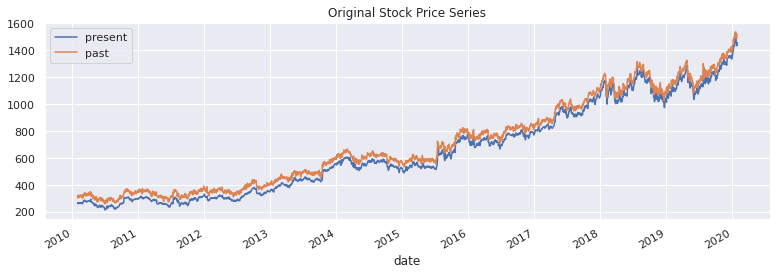

In [0]:
sns.set(rc={'figure.figsize':(13, 4)})
series.plot(linewidth=1.5,title='Original Stock Price Series')

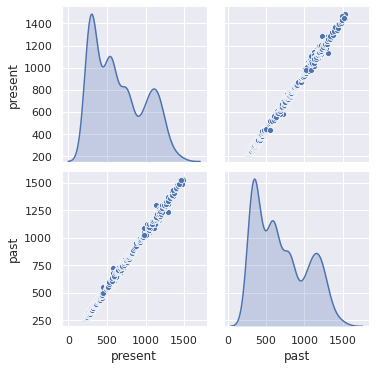

In [0]:
sns.set(rc={'figure.figsize':(13, 4)})
sns.pairplot(series, diag_kind='kde')

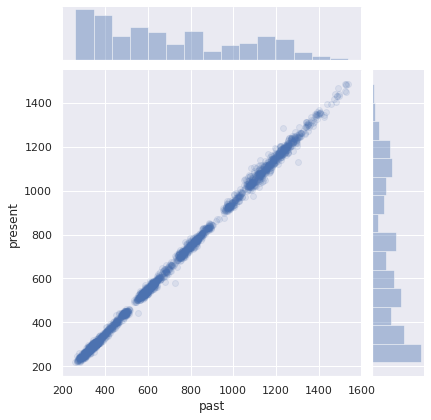

In [0]:
sns.jointplot(x="past", y="present", data=series, alpha=0.1);

## **Robust Regression**

Visual confirmation that data is not normally distributed. Let's run another simple regression, but this time as **robust regression. This will de-weight outliers.** (Note that this is substantially more computationally intensive than standard linear regression, so you may wish to decrease the number of bootstrap resamples (n_boot) or set ci to None.)

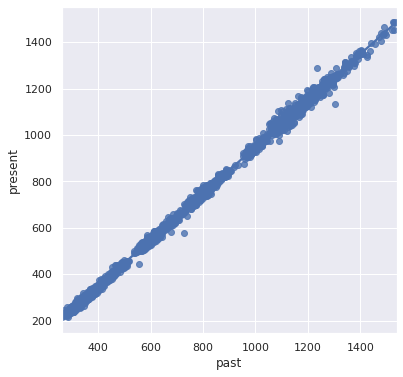

In [0]:
# Plot data and a robust regression model fit
sns.set(rc={'figure.figsize':(6, 6)})
sns.regplot(x="past", y="present", data=series, robust=True, ci=None)

Confirming strong correlation between both time series.

# **Causality Tests**

Ordinarily, regressions reflect "mere" correlations, but Clive Granger argued that causality in economics could be tested for by measuring the ability to predict the future values of a time series using prior values of another time series. The Granger causality test is a statistical hypothesis test for determining whether one time series is useful in forecasting another, first proposed in 1969.

Granger defined the causality relationship based on two principles:

* The cause happens prior to its effect.
* The cause has unique information about the future values of its effect.


A time series X is said to **Granger-cause** Y if it can be shown, usually through a series of t-tests and F-tests on lagged values of X (and with lagged values of Y also included), that those X values provide statistically significant information about future values of Y.

If a time series is a **stationary process**, the test is performed using the level values of two (or more) variables. If the variables are non-stationary, then the test is done using first (or higher) differences. The number of lags to be included is usually chosen using an information criterion, such as the Akaike information criterion or the Schwarz information criterion. 

## **Johansen Cointegration**

Let's first run a **cointegration test**. If two time series, X and Y, are cointegrated, there must exist Granger causality either from X to Y, or from Y to X, both in both directions. (However note that the presence of Granger causality in either or both directions between X and Y does not necessarily imply that the series will be cointegrated.)

**Cointegration between (artificial) previous day close value and current day close value?**

In [0]:
# Johansen Cointegration. H0: There is no cointegration.
import statsmodels.api as sm
import statsmodels.tsa.stattools
statsmodels.tsa.stattools.coint(differenced.past, differenced.present, trend='ct', method='aeg', autolag='aic')

(-11.898685462661787,
 8.516632504064017e-22,
 array([-4.33376918, -3.78435647, -3.49912914]))

Very small p-value. Reject H0. Cointegration present. Granger causality must exit.

## **Granger Causality Test**

Granger causality require stationary data and data in same scale (or normalized) (Granger causality (1969) requires both series to be stationary. Toda-Yamamoto causality requies no such criteria, the test can be applied to both stationary and non stationary data.)

The Null hypothesis for grangercausalitytests is that the time series in the second column, x2, does NOT Granger cause the time series in the first column, x1. **Grange causality means that past values of x2 have a statistically significant effect on the current value of x1, taking past values of x1 into account as regressors**. We reject the null hypothesis that x2 does not Granger cause x1 if the pvalues are below a desired size of the test.

However note that:
* Granger causality cannot take into account third hidden factors affecting both series
* Granger can also not differentiate no-linear relationships (when two factors cause each other). Please see CCM (Convergent Cross Mapping) as a more advanced approach for non-linear relationships.


**Hypothesis test**: Does the (artificial) previous day value cause the current day close value?

In [0]:
# Granger Causality
# Null hypothesis: x2 does NOT Granger cause x1
# Reject null hypothesis if the p-values are below 0.05
import statsmodels.api as sm
import statsmodels.tsa.stattools
statsmodels.tsa.stattools.grangercausalitytests(differenced, maxlag = 5, addconst=True, verbose=True)

Excellent result: p-value is zero. Reject H0. It can be rejected that x2 (past values) does not Granger cause x1 (present values of same time series). Or in layman's terms: there is a strong indication that past price value cause the present price values.